## Creating a weighted Data Loader

From WT 13, start We will work on how to predict both the disease and rice type. Inuitively this seems it will reduce model accuracy to predict disease but JH has pointed out that this is not alwasya the case. 

From wt14 we look into progressive resizing and the weigthed data loader. In WT15 we implemented a weighted data loader. 

In [1]:
# !pip install -Uq --user nbdev
# !pip install huggingface_hub -U
!pip install -Uq --user 'timm==0.6.2.dev0'
!pip install fastai 'fastai>2.7.10'
try: import timm
except ModuleNotFoundError:
    !pip install -Uq 'timm==0.6.2.dev0'
try: import kaggle
except ModuleNotFoundError:
    !pip install -Uq --user 'kaggle'
from fastai.vision.all import *

In [2]:
timm.__version__

'0.6.2.dev0'

In [3]:
# easier to read
Path.BASE_PATh = path = Path('/notebooks/paddy/data')
train_images = path / 'train_images'
test_images = path / 'test_images'
test_images_files = get_image_files(test_images).sorted()
    

In [4]:
path.ls()

(#5) [Path('/notebooks/paddy/data/sample_submission.csv'),Path('/notebooks/paddy/data/test_images'),Path('/notebooks/paddy/data/train_images'),Path('/notebooks/paddy/data/train.csv'),Path('/notebooks/paddy/data/paddy-disease-classification.zip')]

In [5]:
try: df = pd.read_csv(path/'train.csv')
except FileNotFoundError:
    !paddy/get_data.sh
    df = pd.read_csv(path/'train.csv')

In [6]:
# looking at variety
df['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [7]:
# in paddy small we used image dataloader from folder, here we replicate but using DataBlock api
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    get_y=parent_label, 
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=.75)
)

In [8]:
fn = get_image_files(train_images)[0]

In [9]:
parent_label(fn)

'bacterial_panicle_blight'

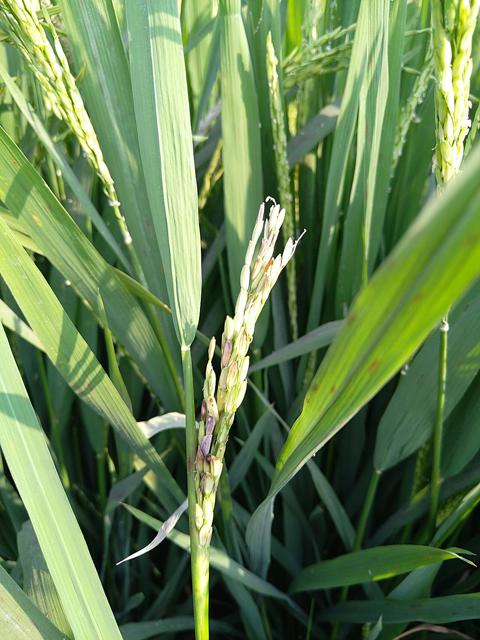

In [10]:
PILImage.create(fn)

In [11]:
dls = dblock.dataloaders(train_images)

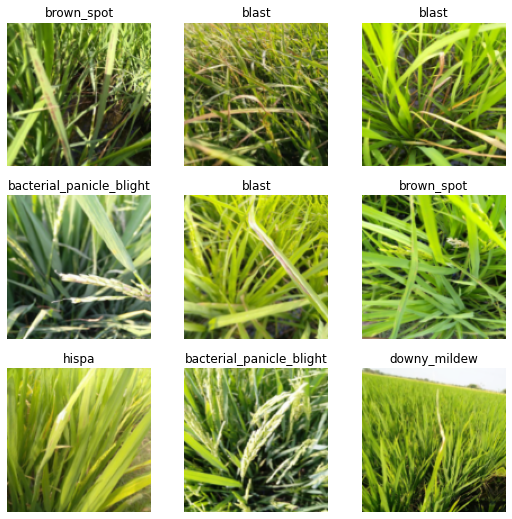

In [12]:
dls.show_batch()

In [13]:
# test with a small set up
learn = vision_learner(dls, resnet18, metrics=error_rate).to_fp16()
learn.fit_one_cycle(1,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.493719,0.947542,0.312350,00:34


## Create the weigths

WT 15 from 26 min
options at hand. resample the weights vs 

In [24]:
# looking at variety
df['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [25]:
# recommended by Jeremy  1/ np.sqrt
# balanced is overkil this way lowest freq
# gets shown ~2x vs highest
w = 1 / np.sqrt(df['label'].value_counts())

In [26]:
df['weights'] = df['label'].map(w)

In [27]:
df

,image_id,label,variety,age,weights
3322,100001.jpg,brown_spot,ADT45,70,0.032191
7791,100002.jpg,normal,ADT45,60,0.023810
6989,100003.jpg,hispa,AtchayaPonni,57,0.025047
2190,100004.jpg,blast,KarnatakaPonni,75,0.023987
6975,100005.jpg,hispa,AtchayaPonni,50,0.025047
...,...,...,...,...,...
9843,110403.jpg,tungro,ADT45,67,0.030317
7790,110404.jpg,normal,ADT45,57,0.023810
5226,110405.jpg,dead_heart,Onthanel,50,0.026334
1369,110406.jpg,blast,ADT45,50,0.023987


In [28]:
# in paddy small we used image dataloader from folder, here we replicate but using DataBlock api
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_y=parent_label, 
    splitter=RandomSplitter(0.2),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=.75)
)

In [29]:
import fastai.callback.data

In [30]:
# https://docs.fast.ai/callback.data.html
# needs a dataset
# from 49 min reviewing errs
files = get_image_files(train_images)
dss = dblock.datasets(files)

In [31]:
# key is str uses attrgetter. As we passing a path it sorts by filename
files = files.sorted(key='name')

In [32]:
files

(#10407) [Path('/notebooks/paddy/data/train_images/brown_spot/100001.jpg'),Path('/notebooks/paddy/data/train_images/normal/100002.jpg'),Path('/notebooks/paddy/data/train_images/hispa/100003.jpg'),Path('/notebooks/paddy/data/train_images/blast/100004.jpg'),Path('/notebooks/paddy/data/train_images/hispa/100005.jpg'),Path('/notebooks/paddy/data/train_images/blast/100006.jpg'),Path('/notebooks/paddy/data/train_images/normal/100007.jpg'),Path('/notebooks/paddy/data/train_images/dead_heart/100008.jpg'),Path('/notebooks/paddy/data/train_images/brown_spot/100009.jpg'),Path('/notebooks/paddy/data/train_images/hispa/100010.jpg')...]

In [33]:
df = df.sort_values(by='image_id')
df

,image_id,label,variety,age,weights
3322,100001.jpg,brown_spot,ADT45,70,0.032191
7791,100002.jpg,normal,ADT45,60,0.023810
6989,100003.jpg,hispa,AtchayaPonni,57,0.025047
2190,100004.jpg,blast,KarnatakaPonni,75,0.023987
6975,100005.jpg,hispa,AtchayaPonni,50,0.025047
...,...,...,...,...,...
9843,110403.jpg,tungro,ADT45,67,0.030317
7790,110404.jpg,normal,ADT45,57,0.023810
5226,110405.jpg,dead_heart,Onthanel,50,0.026334
1369,110406.jpg,blast,ADT45,50,0.023987


In [34]:
# is a dataset method
dss.weighted_dataloaders??

Signature:
dss.weighted_dataloaders(
    wgts,
    bs=64,
    *,
    shuffle_train: 'bool' = None,
    shuffle: 'bool' = True,
    val_shuffle: 'bool' = False,
    n: 'int' = None,
    path: 'str | Path' = '.',
    dl_type: 'TfmdDL' = None,
    dl_kwargs: 'list' = None,
    device: 'torch.device' = None,
    drop_last: 'bool' = None,
    val_bs: 'int' = None,
)
Source:   
@patch
@delegates(Datasets.dataloaders)
def weighted_dataloaders(self:Datasets, wgts, bs=64, **kwargs):
    "Create a weighted dataloader `WeightedDL` with `wgts` for the training set"
    xtra_kwargs = [{}] * (self.n_subsets-1)
    return self.dataloaders(bs=bs, dl_type=WeightedDL, dl_kwargs=({'wgts':wgts}, *xtra_kwargs), **kwargs)
File:      ~/.local/lib/python3.9/site-packages/fastai/callback/data.py
Type:      method


In [35]:
# the weights only work for the train set
df = df.set_index('image_id')
old_wgts = df['weights'].values

In [36]:
old_wgts.shape

(10407,)

In [37]:
dls = dss.weighted_dataloaders(old_wgts, 
                               after_batch=dblock.batch_tfms, 
                               after_item=dblock.item_tfms)

In [38]:
dls.show_batch()

ValueError: 'a' and 'p' must have same size

### Quick mention python debug

55 min wt 15; not required for me as same code did not throw an erro like jeremy. Note how you access the same code line vars. Does not seem to work everywhere for me as in Jeremy video. 



In [40]:
%debug

> /tmp/ipykernel_373/3644589631.py(1)<cell line: 1>()
----> 1 WeightedDLebug



ipdb>  p self.n


*** NameError: name 'self' is not defined


ipdb>  q


In [30]:
WeightedDL??

Init signature:
WeightedDL(
    dataset=None,
    bs=None,
    wgts=None,
    *,
    shuffle: 'bool' = False,
    num_workers: 'int' = None,
    verbose: 'bool' = False,
    do_setup: 'bool' = True,
    pin_memory=False,
    timeout=0,
    batch_size=None,
    drop_last=False,
    indexed=None,
    n=None,
    device=None,
    persistent_workers=False,
    pin_memory_device='',
    wif=None,
    before_iter=None,
    after_item=None,
    before_batch=None,
    after_batch=None,
    after_iter=None,
    create_batches=None,
    create_item=None,
    create_batch=None,
    retain=None,
    get_idxs=None,
    sample=None,
    shuffle_fn=None,
    do_batch=None,
)
Source:        
@delegates()
class WeightedDL(TfmdDL):
    "Weighted dataloader where `wgts` is used for the training set only"
    def __init__(self, dataset=None, bs=None, wgts=None, **kwargs):
        wgts = array([1.]*len(dataset) if wgts is None else wgts)
        self.wgts = wgts/wgts.sum()
        super().__init__(dataset=

In [41]:
# according to docs is applied to rain data only
# Weighted dataloader where `wgts` is used for the training set only"
wgts = [df.loc[o.name, 'weights'] 
        for o in dss.train.items]

In [42]:
# according to jeremy this is not great way to pass the transforms, 
dls = dss.weighted_dataloaders(wgts, 
                               after_batch=dblock.batch_tfms, 
                               after_item=dblock.item_tfms)

# ideal solution is to make this a datablock method, chcek below
# dls = dblock.weighted_dataloaders(wgts)

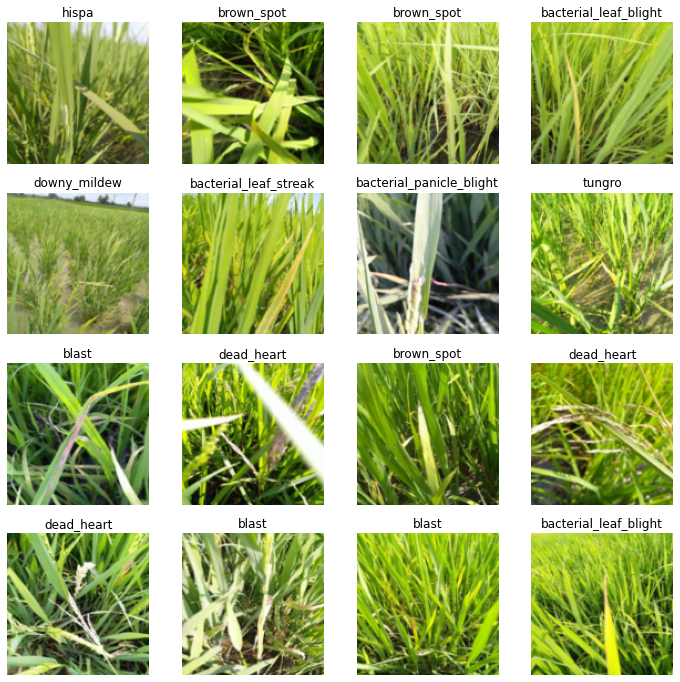

In [43]:
# a lot of bacterials as expected
dls.show_batch(max_n=16)

## New weighted WeightedDL implementation

from datablock, Jeremy created an issue

In [44]:
# weighted data loader from data block
new_wgts = df['weights'].values

In [45]:
new_wgts

array([0.03219114, 0.02380952, 0.02504701, ..., 0.02633403, 0.02398695,
       0.03219114])

In [46]:
# Jeremy actually fixed the code libe on wt 15!!
dblock.weighted_dataloaders??

Signature:
dblock.weighted_dataloaders(
    source,
    wgts,
    bs=64,
    verbose: 'bool' = False,
    *,
    shuffle_train: 'bool' = None,
    shuffle: 'bool' = True,
    val_shuffle: 'bool' = False,
    n: 'int' = None,
    path: 'str | Path' = '.',
    dl_type: 'TfmdDL' = None,
    dl_kwargs: 'list' = None,
    device: 'torch.device' = None,
    drop_last: 'bool' = None,
    val_bs: 'int' = None,
)
Source:   
@patch
@delegates(Datasets.weighted_dataloaders)
def weighted_dataloaders(self:DataBlock, source, wgts, bs=64, verbose:bool=False, **kwargs):
    "Create a weighted dataloader `WeightedDL` with `wgts` for the dataset"
    dss = self.datasets(source, verbose=verbose)
    if not hasattr(wgts, '__array__'): wgts = np.array(wgts)
    trn_wgts = wgts[dss.splits[0]]
    return dss.weighted_dataloaders(trn_wgts, bs=bs, after_batch=self.batch_tfms, after_item=self.item_tfms, **kwargs)
File:      ~/.local/lib/python3.9/site-packages/fastai/callback/data.py
Type:      method


In [47]:
dss = dblock.weighted_dataloaders(files, new_wgts)

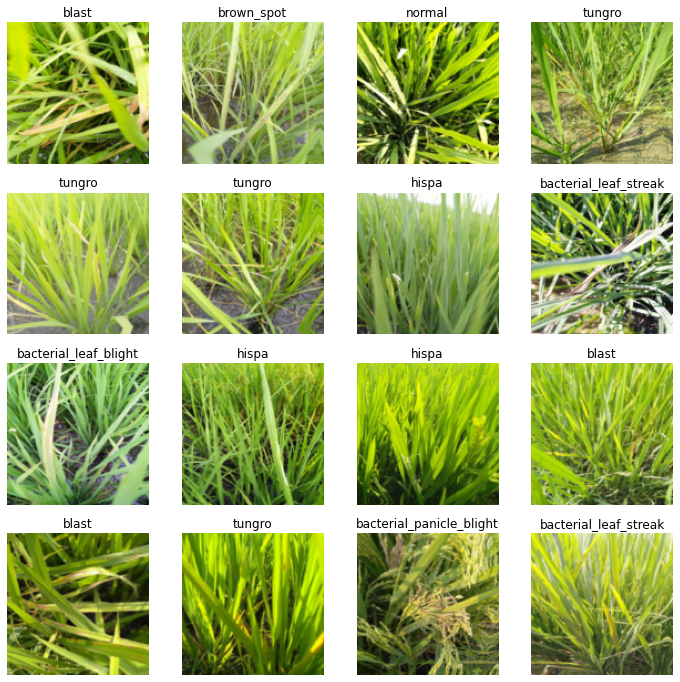

In [48]:
dss.show_batch(max_n=16)

In [49]:
# using resnet 18 for test speed
learner = vision_learner(dls, resnet18, metrics=error_rate).to_fp16()

In [50]:
learner.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.964320,1.499937,0.456511,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.856991,0.802710,0.243633,00:27
1,0.613920,0.541761,0.160500,00:26
2,0.374838,0.366143,0.102835,00:25
3,0.198532,0.229982,0.068236,00:25
4,0.124907,0.182510,0.055262,00:26


In [ ]:
# timm.list_models("conv*") # too long
# learner = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()
# learner.fine_tune(5, 0.01)